In [1]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pickle as pkl
import numpy as np

import itertools
import glob

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo
from M1_util_train_test import load_model, test
import mnl
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir


In [41]:
model_type = 'SAE'
load_model_name = 'Autoencoder'
load_model_file = 'sae'
model_code = 'M1_A1'
zoomlevel = 'zoom13'
output_dim = 1
model_run_date = '22021001'
sampling = 's'
data_version = '1337'

variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

# Load Model Embeddings

In [42]:
with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [43]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

# Load Trip Behavior

In [6]:
file = "origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, data_version)

train_test_index = df_pivot['train_test'].astype(bool).to_numpy()
# train_test_index = np.random.rand(len(df_pivot)) < 0.2

y = df_pivot[variable_names].to_numpy()
y_train = y[~train_test_index,:4]
y_test = y[train_test_index,:4]

In [44]:
x_train = aggregate_embeddings[~train_test_index, :]
x_test = aggregate_embeddings[train_test_index, :]

# MNL for Mode Share

In [45]:
# dataloader and model definition

trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
testloader = DataLoader(testset, batch_size=len(testset), shuffle=True)

kldivloss = nn.KLDivLoss(reduction='sum')
mseloss = nn.MSELoss(reduction='none')

In [46]:
wd_list = [0,0.0001,0.001,0.01]
lr_list = [0.0002]

for (lr, wd) in itertools.product(lr_list, wd_list):
    # model setup
    model = mnl.MNL(n_alts=4, n_features=x_train.shape[-1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # model training

    ref1 = 0
    ref2 = 0

    for epoch in range(400):

        kl_ = 0
        mse_ = 0
        mse1_ = 0
        mse2_ = 0
        mse3_ = 0
        mse4_ = 0

        for batch, (x_batch, y_batch) in enumerate(trainloader):
            # Compute prediction and loss
            util = model(x_batch)
            probs = torch.log(nn.functional.softmax(util, dim=1))
            kl = kldivloss(probs, y_batch)
    #         kl = kldivloss(torch.log(util), y_batch)
            kl_ += kl.item()

            mse = mseloss(torch.exp(probs), y_batch)
    #         mse = mseloss(util, y_batch)
            mse_ += mse.sum().item()
            mse1_ += mse[:,0].sum().item()
            mse2_ += mse[:,1].sum().item()
            mse3_ += mse[:,2].sum().item()
            mse4_ += mse[:,3].sum().item()
            mse = mse.sum()

            # Backpropagation
            optimizer.zero_grad()
            kl.backward()
            optimizer.step()

        train_kl = kl_/len(trainset)
        train_mse = np.sqrt(mse_/len(trainset))
        train_mse1 = np.sqrt(mse1_/len(trainset))
        train_mse2 = np.sqrt(mse2_/len(trainset))
        train_mse3 = np.sqrt(mse3_/len(trainset))
        train_mse4 = np.sqrt(mse4_/len(trainset))

        if epoch % 10 == 0:
            print(f"[epoch: {epoch:>2d}] Train KL loss: {train_kl:.3f} \
                RMSE {train_mse:.3f} \
                {train_mse1:.3f} {train_mse2:.3f} {train_mse3:.3f} {train_mse4:.3f}")
        loss_ = train_kl

        if epoch % 5 == 0:
            if epoch > 50:
                if (np.abs(loss_ - ref1)/ref1<ref1*0.01) & (np.abs(loss_ - ref2)/ref2<ref2*0.01):
                    print("Early stopping at epoch", epoch)
                    break
                if (ref1 < loss_) & (ref1 < ref2):
                    print("Diverging. stop.")
                    break
                if loss_ < best:
                    best = loss_
                    best_epoch = epoch
            else:
                best = loss_
                best_epoch = epoch

            ref2 = ref1
            ref1 = loss_

        if epoch % 10 == 0:

            kl_ = 0
            mse_ = 0 
            mse1_ = 0
            mse2_ = 0
            mse3_ = 0
            mse4_ = 0

            for batch, (x_batch, y_batch) in enumerate(testloader):
                util = model(x_batch)
                probs = torch.log(nn.functional.softmax(util,dim=1))
                kl = kldivloss(probs, y_batch)
        #         kl = kldivloss(torch.log(util), y_batch)
                kl_ += kl.item()

                mse = mseloss(torch.exp(probs), y_batch)
        #         mse = mseloss(util, y_batch)
                mse_ += mse.sum().item()
                mse1_ += mse[:,0].sum().item()
                mse2_ += mse[:,1].sum().item()
                mse3_ += mse[:,2].sum().item()
                mse4_ += mse[:,3].sum().item()

            test_kl = kl_/len(testset)
            test_mse = np.sqrt(mse_/len(testset))
            test_mse1 = np.sqrt(mse1_/len(testset))
            test_mse2 = np.sqrt(mse2_/len(testset))
            test_mse3 = np.sqrt(mse3_/len(testset))
            test_mse4 = np.sqrt(mse4_/len(testset))

            r1 = r2_score(y_batch.numpy()[:,0],torch.exp(probs).detach().numpy()[:,0])
            r2 = r2_score(y_batch.numpy()[:,1],torch.exp(probs).detach().numpy()[:,1])
            r3 = r2_score(y_batch.numpy()[:,2],torch.exp(probs).detach().numpy()[:,2])
            r4 = r2_score(y_batch.numpy()[:,3],torch.exp(probs).detach().numpy()[:,3])

            print(f"[epoch: {epoch:>2d}] Test KL loss: {kl_/len(testset):.3f}\
                    RMSE {np.sqrt(mse_/len(testset)):.3f} \
                    {np.sqrt(mse1_/len(testset)):.3f} {np.sqrt(mse2_/len(testset)):.3f} {np.sqrt(mse3_/len(testset)):.3f} {np.sqrt(mse4_/len(testset)):.3f}")
            print(f"\t\t\t\t\t\t\tR2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")


    with open(out_dir+sampling+"_"+model_code+"_mode_choice.csv", "a") as f:
        f.write("%s,%s,%s,%s,%.4f,%d,%.5f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
            (model_run_date, model_type, zoomlevel, "MNL", lr, -1, wd, 
              train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
              test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
              r1, r2, r3, r4))

[epoch:  0] Train KL loss: 0.675                 RMSE 0.604                 0.174 0.494 0.156 0.257
[epoch:  0] Test KL loss: 0.343                    RMSE 0.395                     0.153 0.311 0.098 0.162
							R2 score: 0.017 -0.898 -5.286 -1.857 
[epoch: 10] Train KL loss: 0.177                 RMSE 0.255                 0.130 0.190 0.057 0.093
[epoch: 10] Test KL loss: 0.150                    RMSE 0.232                     0.115 0.175 0.043 0.090
							R2 score: 0.445 0.400 -0.182 0.111 
[epoch: 20] Train KL loss: 0.143                 RMSE 0.219                 0.114 0.158 0.056 0.082
[epoch: 20] Test KL loss: 0.118                    RMSE 0.197                     0.100 0.143 0.041 0.081
							R2 score: 0.585 0.597 -0.092 0.283 
[epoch: 30] Train KL loss: 0.130                 RMSE 0.206                 0.109 0.147 0.056 0.076
[epoch: 30] Test KL loss: 0.107                    RMSE 0.187                     0.097 0.134 0.041 0.076
							R2 score: 0.604 0.646 -0.092 0.371 
[e

[epoch: 130] Train KL loss: 0.113                 RMSE 0.187                 0.101 0.132 0.055 0.065
[epoch: 130] Test KL loss: 0.100                    RMSE 0.183                     0.101 0.129 0.041 0.071
							R2 score: 0.572 0.674 -0.088 0.457 
[epoch: 140] Train KL loss: 0.112                 RMSE 0.186                 0.101 0.131 0.055 0.065
[epoch: 140] Test KL loss: 0.100                    RMSE 0.183                     0.102 0.128 0.041 0.070
							R2 score: 0.568 0.677 -0.089 0.464 
[epoch: 150] Train KL loss: 0.111                 RMSE 0.185                 0.100 0.131 0.055 0.065
[epoch: 150] Test KL loss: 0.099                    RMSE 0.182                     0.101 0.128 0.041 0.070
							R2 score: 0.574 0.681 -0.083 0.466 
[epoch: 160] Train KL loss: 0.111                 RMSE 0.185                 0.100 0.130 0.055 0.064
[epoch: 160] Test KL loss: 0.099                    RMSE 0.182                     0.101 0.128 0.041 0.070
							R2 score: 0.575 0.681 -0.094 0.4

[epoch: 110] Train KL loss: 0.115                 RMSE 0.191                 0.103 0.135 0.056 0.066
[epoch: 110] Test KL loss: 0.100                    RMSE 0.183                     0.099 0.130 0.040 0.072
							R2 score: 0.588 0.667 -0.067 0.438 
[epoch: 120] Train KL loss: 0.115                 RMSE 0.190                 0.102 0.135 0.055 0.066
[epoch: 120] Test KL loss: 0.100                    RMSE 0.183                     0.099 0.130 0.041 0.072
							R2 score: 0.588 0.668 -0.075 0.438 
[epoch: 130] Train KL loss: 0.114                 RMSE 0.189                 0.102 0.134 0.055 0.066
[epoch: 130] Test KL loss: 0.100                    RMSE 0.183                     0.099 0.129 0.040 0.071
							R2 score: 0.587 0.672 -0.070 0.445 
[epoch: 140] Train KL loss: 0.114                 RMSE 0.189                 0.102 0.134 0.055 0.065
[epoch: 140] Test KL loss: 0.100                    RMSE 0.184                     0.100 0.130 0.041 0.071
							R2 score: 0.579 0.669 -0.079 0.4

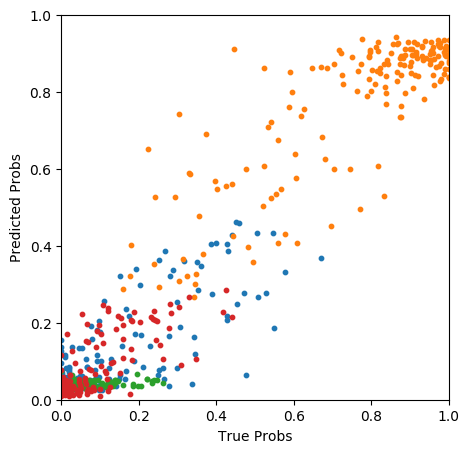

In [10]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for i in range(4):
    ax.scatter(y_batch.detach().numpy()[:,i], torch.exp(probs).detach().numpy()[:,i], s=10)

ax.set_xlabel("True Probs")
ax.set_ylabel("Predicted Probs")
ax.set_xlim([0,1])
ax.set_ylim([0,1])
plt.show()

# LR for trip generation

In [11]:
trpgen_train =  y[~train_test_index,1]
trpgen_test =  y[train_test_index,1]

In [47]:
lr = linear_model.LinearRegression()
lr.fit(x_train, trpgen_train)
with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
    f.write("%s,%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], -1, 
        lr.score(x_train, trpgen_train), lr.score(x_test, trpgen_test), 'lr', zoomlevel,
        np.sum(lr.coef_ != 0), len(lr.coef_)))
print(lr.score(x_train, trpgen_train), lr.score(x_test, trpgen_test))

0.9999999843273655 0.3040118983912974


In [13]:
# for a in np.linspace(0.005, 0.014, 10):
#     lasso = linear_model.Lasso(alpha=a)
#     lasso.fit(x_train, trpgen_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.6f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', zoomlevel,
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))
#     print(lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test))

In [48]:
for a in np.linspace(1,4,10):
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, trpgen_train)
    with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
        f.write("%s,%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
            ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
            np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print(ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test))

0.8909607950979117 0.6790313259938814
0.8769976803531805 0.6897446556015933
0.8660827949529937 0.6967019342607351
0.8571765880658048 0.7015524107024605
0.8496892739792241 0.7051006334595775
0.8432541060042492 0.7077902935485098
0.837628453146014 0.7098805349966293
0.8326432317176822 0.7115411406751776
0.8281766312874024 0.7128814662330778
0.8241374982068834 0.7139772356130665
